# 02. Summary statistics of structural variants generated with Lumpy
----

[Lumpy](https://github.com/arq5x/lumpy-sv) uses discordant **paired-ends** (i.e. distance between pairs significantly further that the expected insert size) and **split reads** (i.e. reads with subfragments mapping to non-contiguous positions) to identify structural variants (e.g. insertions, deletions, duplications). Lumpy reports structural variants (SVs) in [VCF](http://www.1000genomes.org/wiki/analysis/variant%20call%20format/vcf-variant-call-format-version-41) or [BEDPE](http://bedtools.readthedocs.org/en/latest/content/general-usage.html). Here there are various functions that allow to summarize (SVs) information encoded in BEDPE files.

## Python libraries and default parameters
---

In [1]:
%pylab inline

import os
import pandas as pd

# FONT
plt.rcParams['font.size'] = 20 
plt.rcParams['font.weight'] = 'medium' 
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'Arial' 

# LINES
plt.rcParams['lines.linewidth'] = 2.0

# LEGEND
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.frameon'] = False

# SAVING FIGURES
#plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['savefig.bbox'] = 'tight'

Populating the interactive namespace from numpy and matplotlib


## Functions definition
---

In [2]:
# Imports BEDPE file given a relative file name

def import_bedpe(file_name):
    
    infile = 'data/%s' % file_name

    # Header
    header = pd.read_table(infile, nrows = 1, header = None)
    header = list(header.ix[0, :])
    header[0] = 'CHROM_A'
    
    # Data
    df = pd.read_table(infile, header = None, comment = '#')
    df.columns = header
    
    print 'Number of SVs imported = %i' % len(df)
    
    return df

In [3]:
# Three plots summarizing the number of reads of each class supporting the structural variant:
# discordant paired-ends (PE)
# split reads (SR)
# PE + SR = SU

def support_pe_sr():
    
    plt.close('all')
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    f.subplots_adjust(wspace = 0.50, hspace = 1)

    # Make a local copy of the data
    df = svs.copy()
    
    # Extract the number of reads supporting from each class (i.e. discordant paired-ends or split reads)
    # supporting each variant
    df['SU'] = [int(i.split(':')[1]) for i in df['SAMPLE1']]
    df['PE'] = [int(i.split(':')[2]) for i in df['SAMPLE1']]
    df['SR'] = [int(i.split(':')[3]) for i in df['SAMPLE1']]
   
    # Histogram
    def plot_hist(support, color):  
        ax1.hist(df[support], bins = arange(100), normed = True, color = color, histtype = 'step',
                 label = support, linewidth = 2, alpha = 0.85, cumulative = True)
    
    plot_hist('PE', 'blue')
    plot_hist('SR', 'orange')
    plot_hist('SU', 'green')
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 20)
    ax1.set_xlabel('Number of reads')
    ax1.set_ylabel('Fraction of calls')
    ax1.legend(fontsize = 14, loc = 'lower right')
                   
    # Scatter plot
    ax2.scatter(log10(df['SU']), df['PE'] / df['SU'], color = 'gray', alpha = 0.10)
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_xlim(0, 5)
    ax2.set_xlabel('log10(SU)')
    ax2.set_ylabel('Fraction of PE')    
    
    # Barplot
    values = []
    ind = arange(3)
    width = 0.25
    for r in arange(3):
        
        cond1 = df['PE'] > r
        cond2 = df['SR'] > r   
        values.append((1. * len(df[cond1])) / len(df))
        values.append((1. * len(df[cond2])) / len(df))
        values.append((1. * len(df[cond1 & cond2])) / len(df))
    
    rects1 = ax3.bar(ind, values[0:3], width, color = 'blue')
    rects2 = ax3.bar(ind + width, values[3:6], width, color = 'orange')
    rects3 = ax3.bar(ind + 2*width, values[6:], width, color = 'green')
    ax3.set_ylabel('Fraction of calls')
    ax3.set_xticks(ind + width)
    ax3.set_ylim(0, 1)
    ax3.set_xlim(-0.2, 3)
    ax3.set_xticklabels( ('>0', '>1', '>2') )
    ax3.set_xlabel('Number of reads\nsupporting the call')
    ax3.legend( (rects1[0], rects2[0], rects3[0]), ('PE', 'SR', 'SU'), fontsize = 14, bbox_to_anchor=(1.5, 1) )
    
    # Save plot
    outfile = 'figures/structural.variants.calls.reads.support.png'
    savefig(outfile, bbox_inches = 'tight', dpi = 400)   

In [4]:
# Barplot with the relative frequency of each type of SV

def types_of_variants():
    
    # Plot scaffold
    plt.close('all')
    f, (ax1) = plt.subplots(1, 1, figsize=(5, 5))
    
    # Retrieve data
    df = svs.copy()
    
    # Get the variant types
    variant_types = set(df['TYPE'])
    #print variant_types
    
    # Barplot
    ind = arange(len(variant_types))
    width = 0.35
    variant_totals = []
    for variant_type in variant_types:        
        variant_totals.append(len(df[df['TYPE'] == variant_type]))    
    rel_freqs = [(1.*i)/sum(variant_totals) for i in variant_totals]
    rects = ax1.bar(ind, rel_freqs, width, color = 'gray')
    
    # Axes and labels
    ax1.set_ylabel('Fraction of calls')
    ax1.set_xticks(ind + width*0.5)
    ax1.set_ylim(0, 1)
    ax1.set_xlim(-1, 4)
    ax1.set_xticklabels( list(set(df['TYPE'])) )
    ax1.set_xlabel('Type of structural variant')
    
    # More labels
    labels = {}
    labels['DUP'] = 'Duplication'
    labels['INV'] = 'Inversion'
    labels['DEL'] = 'Deletion'
    labels['BND'] = 'Complex Rearrangement'
    
    for a, b in zip(arange(len(variant_types)), [1., 0.9, 0.8, 0.7]):
        
        ax1.text(ind[a] + 0.05, 0.05 + (1. * variant_totals[a]) / sum(variant_totals), variant_totals[a],
                 fontsize = 16, horizontalalignment = 'left')
        
        ax1.text(4.5, b, '%s = %s' % (list(set(df['TYPE']))[a], labels[list(set(df['TYPE']))[a]]))
        
    # Save plot
    outfile = 'figures/types.structural.variants.png'
    savefig(outfile, bbox_inches = 'tight', dpi = 400)   

In [14]:
# Three plots summarizing how the Lumpy confidence intervals in the breakpoints relate to other metrics

def confidence_interval_breakpoints():

    # Plot scaffold
    plt.close('all')
    f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(4, 12))
    f.subplots_adjust(wspace = 1, hspace = 0.5)
    
    # Retrieve data
    df = svs.copy()
    df['SU'] = [int(i.split(':')[1]) for i in df['SAMPLE1']]
     
    labels = {}
    labels['DUP'] = 'blue'
    labels['INV'] = 'orange'
    labels['DEL'] = 'green'
    labels['BND'] = 'brown'
    
    # Calculate confidence interval for both breakends of the structural variants
    df['A_CI'] = df['END_A'] - df['START_A']
    df['B_CI'] = df['END_B'] - df['START_B']
    
    # Confidence interval distribution
    for variant_type, i in zip(set(df['TYPE']), arange(1, 9, 2)):
        
        k = df[df['TYPE'] == variant_type]
        myhist = ax1.hist(list(k['A_CI']), histtype = 'step', bins = arange(1000),
                          label = variant_type + '-start', normed = True, cumulative = True,
                          alpha = 0.75, linewidth = 2, color = labels[variant_type])
        myhist = ax1.hist(list(k['B_CI']), histtype = 'step', bins = arange(1000),
                          label = variant_type + '-end', normed = True, cumulative = True,
                          alpha = 0.75, linewidth = 2, color = labels[variant_type],
                             linestyle = 'dashed')
        
    ax1.set_xlim(0, 600)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Breakpoint CI (bp)')
    ax1.set_ylabel('Fraction of calls')
    ax1.legend(loc = 'lower right', fontsize = 10, ncol = 2, bbox_to_anchor=(2, 0.5))
        
    # CI vs reads support
    ax2.scatter(log10(df['SU']), df['A_CI'], color = 'gray', alpha = 0.1)
    ax2.scatter(log10(df['SU']), df['B_CI'], color = 'gray', alpha = 0.1)
    ax2.set_xlim(0, 5)
    ax2.set_ylim(0, 700)
    ax2.set_xlabel('log10(SU)')
    ax2.set_ylabel('Breakpoint CI (bp)')
    
    # CI vs variant size (for DUP, INV, DEL variants only --BND do not have size)
    df_sub = df[df['TYPE'] != 'BND'].copy()
    df_sub['SVLEN'] = [abs(int(i.split(';')[1].split('=')[1])) for i in df_sub['INFO']]
    ax3.scatter(log10(df_sub['SVLEN']), df_sub['A_CI'], color = 'gray', alpha = 0.1)
    ax3.scatter(log10(df_sub['SVLEN']), df_sub['B_CI'], color = 'gray', alpha = 0.1)
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 700)
    ax3.set_xlabel('log10(variant size)')
    ax3.set_ylabel('Breakpoint CI (bp)')

    outfile = 'figures/breakpoints.confidence.interval.png'
    savefig(outfile, bbox_inches = 'tight', dpi = 400)  

# Apply functions
----

In [6]:
svs = import_bedpe('svs.bedpe')

Number of SVs imported = 1000


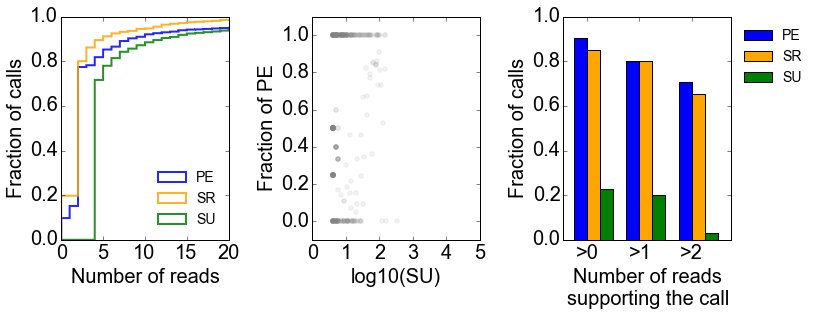

In [7]:
support_pe_sr()

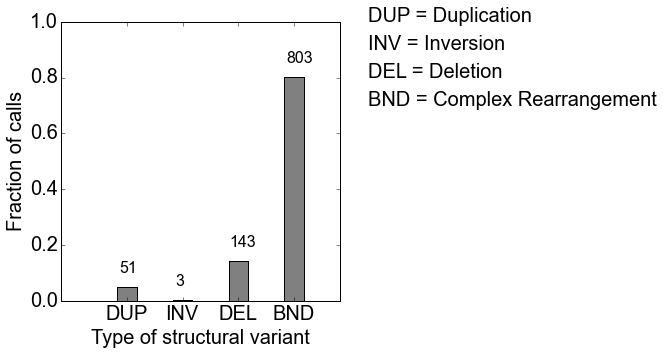

In [8]:
types_of_variants()

In [ ]:
confidence_interval_breakpoints()

## Summary
----

* ~80% of SVs are complex rearrangements
* More than 70% of SVS are supported by >2 PE or SR reads and by a total of >4 reads (this is reflects that 4 reads is the minimum default required by Lumpy to call a SV)
* More than 80% of SVs are supported by either PE or SR, with <25% supported by both types of reads
* For CI\* on the breakpoint genomic coordinates there is a bimodal behaviour: ~40-80 of variants have reltively precise breakpoints (CI<25 bp), while the rest show a broad range in the precision of the breakpoints (up to 700 bp)
    - The precision of the CI does not correlate with the total number of reads supporting the variant or its size

\* *For each SV Lumpy produces two CI, each indicating the interval of genomic coordinates where most likely the breakpoint lies*